In [2]:
import chess
import chess.engine
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import numpy as np

In [4]:
training_data = pd.read_csv('data/features_v2.csv', index_col=0)
raw_data = pd.read_csv('data/lichess_db_puzzle.csv', index_col=0)

In [5]:
# Define the features and target variable
X = pd.get_dummies(training_data, columns=['moved_piece_type'], dtype=int).drop(columns=['Ranking'])
X["ends_with_check"] = X["ends_with_check"].astype(int)
X = X.astype(float)

y = training_data['Ranking'].astype(float)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3111012, 16)
X_test shape: (777753, 16)
y_train shape: (3111012,)
y_test shape: (777753,)


In [16]:
raw_data.Popularity

PuzzleId
00008    94
0000D    96
0008Q    90
0009B    87
000Vc    73
         ..
zzzc4    89
zzzco    88
zzzhI    84
zzzhg    89
zzzw8    91
Name: Popularity, Length: 3888765, dtype: int64

In [8]:
raw_data['NbPlays'].describe()

count    3.888765e+06
mean     1.674349e+03
std      4.459941e+03
min      0.000000e+00
25%      9.300000e+01
50%      3.710000e+02
75%      1.325000e+03
max      1.007625e+06
Name: NbPlays, dtype: float64

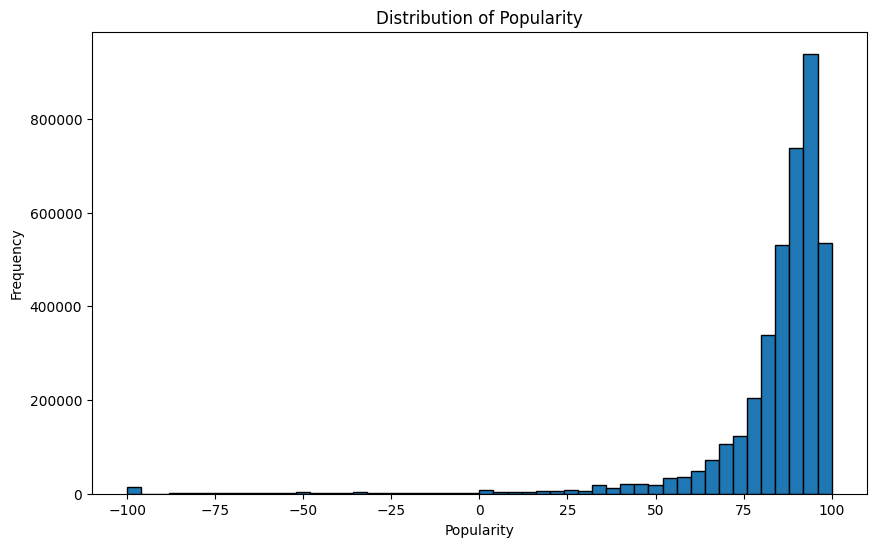

In [17]:
import matplotlib.pyplot as plt

# Plot the NbPlays column
plt.figure(figsize=(10, 6))
plt.hist(raw_data.Popularity, bins=50, edgecolor='k')
plt.title('Distribution of Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.show()

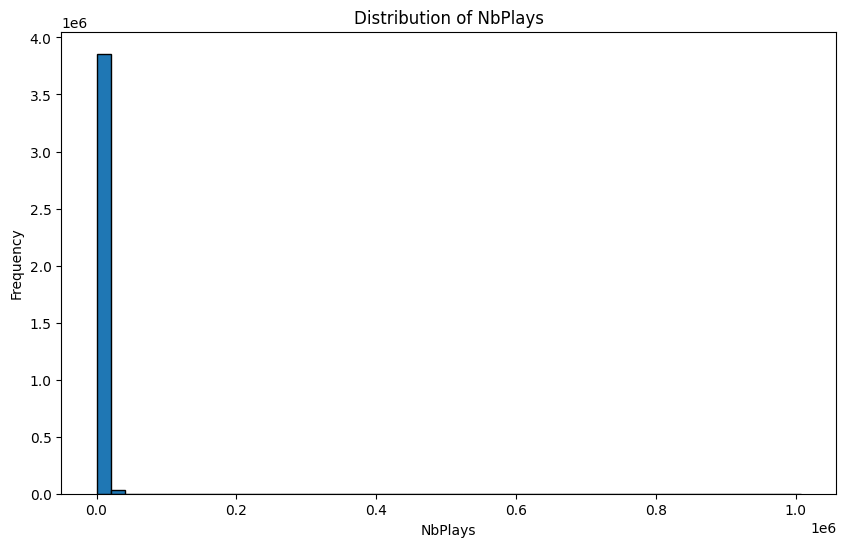

In [7]:
import matplotlib.pyplot as plt

# Plot the NbPlays column
plt.figure(figsize=(10, 6))
plt.hist(raw_data['NbPlays'], bins=50, edgecolor='k')
plt.title('Distribution of NbPlays')
plt.xlabel('NbPlays')
plt.ylabel('Frequency')
plt.show()

In [10]:
# Calculate the 90th percentile value
percentile_90 = raw_data['NbPlays'].quantile(0.90)

# Clip the NbPlays column to the 90th percentile
nb_clipped = raw_data['NbPlays'].clip(upper=percentile_90)

# Display the updated column statistics
print(nb_clipped.describe())

count    3.888765e+06
mean     1.018090e+03
std      1.352383e+03
min      0.000000e+00
25%      9.300000e+01
50%      3.710000e+02
75%      1.325000e+03
max      4.252000e+03
Name: NbPlays, dtype: float64


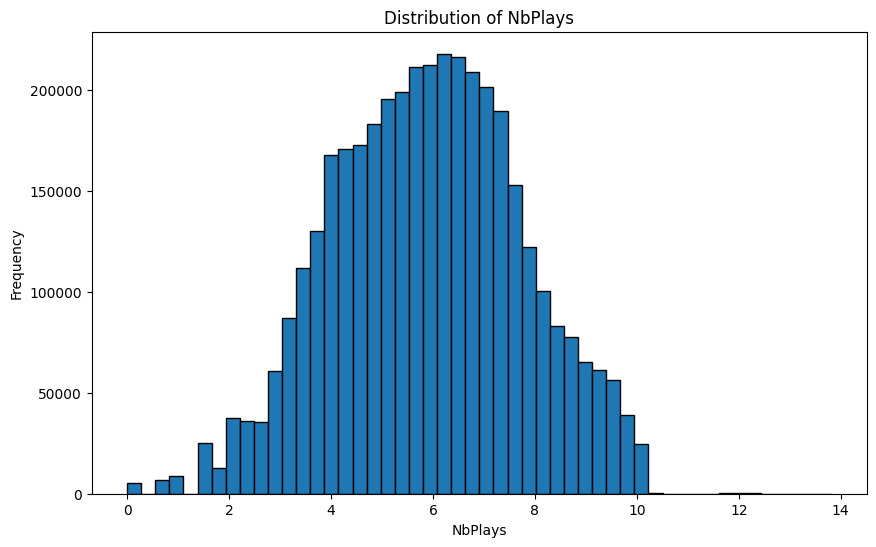

In [24]:
# Plot the NbPlays column
plt.figure(figsize=(10, 6))
plt.hist(np.log(raw_data['NbPlays']+1), bins=50, edgecolor='k')
plt.title('Distribution of NbPlays')
plt.xlabel('NbPlays')
plt.ylabel('Frequency')
plt.show()

In [25]:
np.log(raw_data['NbPlays']+1)

PuzzleId
00008     8.706987
0000D    10.164582
0008Q     6.295266
0009B     6.342121
000Vc     4.521789
           ...    
zzzc4     5.916202
zzzco     6.985642
zzzhI     4.248495
zzzhg     6.218600
zzzw8     5.905362
Name: NbPlays, Length: 3888765, dtype: float64

In [23]:
# Initialize the XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Step size shrinkage
    max_depth=6,  # Maximum tree depth
    subsample=0.8,  # Fraction of samples used per tree
    colsample_bytree=0.8,  # Fraction of features used per tree
    random_state=42,
    sample_weight=nb_clipped
)

# Train the model
xgb_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [5]:
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 133705.94
R^2 Score: 0.55


In [26]:
from sklearn.model_selection import KFold

# Define the k-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store the results
mse_scores = []
r2_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    sample_weight_train = np.log(raw_data['NbPlays']+1).iloc[train_index]
        
    # Initialize the XGBoost Regressor
    xgb_model = XGBRegressor(
        n_estimators=100,  # Number of trees
        learning_rate=0.1,  # Step size shrinkage
        max_depth=6,  # Maximum tree depth
        subsample=0.8,  # Fraction of samples used per tree
        colsample_bytree=0.8,  # Fraction of features used per tree
        random_state=100,
        
    )
    
    # Train the model
    xgb_model.fit(X_train, y_train, sample_weight=sample_weight_train)
    
    # Predict the target variable
    y_pred = xgb_model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Append the results to the lists
    mse_scores.append(mse)
    r2_scores.append(r2)

# Calculate the average scores
avg_mse = np.mean(mse_scores)
avg_r2 = np.mean(r2_scores)

print(f"Average Mean Squared Error: {avg_mse:.2f}")
print(f"Average R^2 Score: {avg_r2:.2f}")

Average Mean Squared Error: 134002.49
Average R^2 Score: 0.55


In [24]:
xgb_model.save_model('models/xgb_model_weights_v2_full_training_data_100.json')

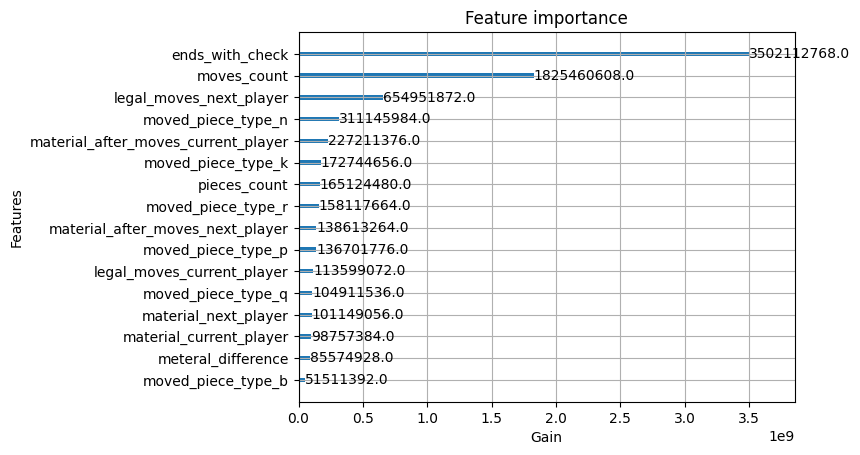

In [26]:
from xgboost import XGBClassifier
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Plot feature importance
plot_importance(xgb_model, importance_type='gain')  # Use 'weight', 'gain', or 'cover'
plt.xlabel("Gain")
plt.show()

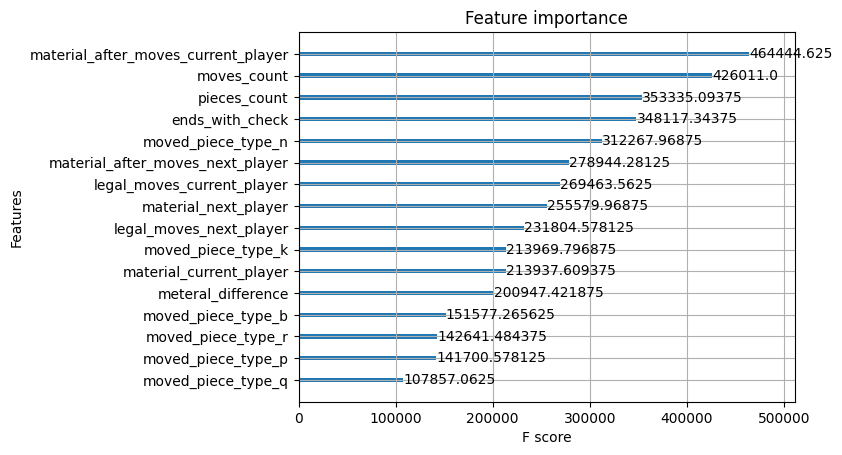

In [20]:
# Plot feature importance
plot_importance(xgb_model, importance_type='cover')  # Use 'weight', 'gain', or 'cover'
plt.show()

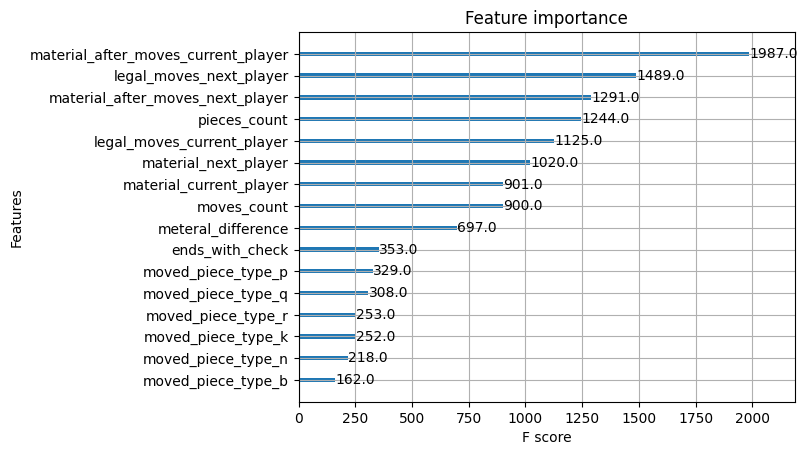

In [21]:
# Plot feature importance
plot_importance(xgb_model, importance_type='weight')  # Use 'weight', 'gain', or 'cover'
plt.show()